
# Amazon Fine Food Reviews Analysis¶ **bold text**

Data Source: **https://www.kaggle.com/snap/amazon-fine-food-reviews**

**The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.**

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the 
review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review


Text - text of the review

Objective:- Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


**[Q] How to determine if a review is positive or negative?** 

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

**[1.1] Loading the data **

**The dataset is available in two forms**

.csv file

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. 

If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
import sqlite3

In [ ]:
#read data
con=sqlite3.connect('/content/drive/MyDrive/amazon data/database.sqlite')

In [ ]:
#negelect data review having score=3

filtered_data=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3''',con)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
def partition(x):
  if x<3:
    return 'negetive'
  return 'positive'

In [ ]:
filtered_data['Score']=filtered_data['Score'].map(partition)

In [ ]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
filtered_data['Score'].value_counts()

positive    443777
negetive     82037
Name: Score, dtype: int64

In [ ]:
display=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3 
                              AND UserId="AR5J8UI46CURR"
                              ORDER BY ProductID''',con)

In [ ]:
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


*Observations: *

1) As in above table, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator.Score,Time, Summary and Text shows same content

2) Also for all 5 product, shows same time.

3) Here we observed that, product is same, only the flavour is different

4) so we will remove this duplication and keep any one product which all these features so we removing duplicates.

In [ ]:
#sort data according to product Id in ascending order

sorted_data=filtered_data.sort_values('ProductId',ascending=True,inplace=False,kind='quicksort',na_position='last')


In [ ]:
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

In [ ]:
#After removing duplicaties see how much % of data  still remains
((final['Id'].size)/(filtered_data['Id'].size))*100

69.25890143662969

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## **Now, we do preprocessing like removal of stop words, html tags and make all letters in lowercase.**

In [ ]:
import re
i=0
for sent in final['Text'].values:
  if (re.findall('<.*?>',sent)):
    print(i)
    print(sent)
    break
  i+=1



6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop=set(stopwords.words('english')) #set of stopwords

sno=nltk.stem.SnowballStemmer('english') #intialising snowball stemmer

In [ ]:
#funtion to clean htmal tags
def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,' ',sentence)
  return cleantext

#function to clean punctuations

def cleanpunc(sentence):
  cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned=re.sub(r'[.|,|(|)|\|/]',r'',cleaned)
  return cleaned

In [ ]:
print(stop)
print(sno.stem('tasty'))

{'just', 'it', 'theirs', 'between', "hasn't", 'won', 're', 'than', "wasn't", 'should', 'isn', 'an', 'these', 'don', 'if', 'same', 'o', 'and', 'a', 'for', 'yours', 'be', 'then', 'mightn', 'hers', 'he', "you'll", 'at', "haven't", "hadn't", 'what', 'as', 'shan', 'its', 'did', 'with', 'to', 'up', 'haven', 'myself', 've', 'were', 'of', 'has', 'd', 'all', 'wouldn', 'our', 'once', 'weren', 'll', 'other', 'yourself', 'shouldn', 'ours', 'hasn', 'until', 'their', "wouldn't", 'wasn', 'no', 'very', 'him', 'here', 'her', 'will', 'my', 'his', 'against', 'where', 'hadn', "aren't", 'itself', 'ain', 'again', 'himself', 'are', 'there', 'how', 'had', 'but', "that'll", 'm', "mightn't", "shouldn't", 'which', "weren't", 'over', 'this', 'am', 'when', 't', "mustn't", 'because', 'or', "doesn't", 'does', 'been', 'in', 'whom', 'who', 'themselves', 'why', 'further', "couldn't", 'can', "isn't", "should've", "it's", 'such', 'is', "she's", 'down', 'on', 'off', "won't", 'aren', 'they', "didn't", 'below', 's', "you've

In [ ]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
final_string=[]
all_positive_words=[]
all_negetive_words=[]
str1=''
s=''
for sent in final['Text'].values:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  for w in sent.split():
    for cleanword in cleanpunc(w).split():
      if ((cleanword.isalpha()) & (len(cleanword)>2)):
        if (cleanword.islower() not in stop):
          s=(sno.stem(cleanword.lower()))
          filtered_sentence.append(s)
          if (final['Score'].values)[i]=='positive':
            all_positive_words.append(s)
          if (final['Score'].values)[i]=='negetive':
            all_negetive_words.append(s)
        else:
          continue
      else:
        continue
  str1=' '.join(filtered_sentence)
  final_string.append(str1)
  i+=1

In [ ]:
final['CleanText']=final_string


In [ ]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witti littl book make son laugh loud reci...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read these sendak book and watch the real...


In [ ]:
final['Time']=pd.to_datetime(final['Time'],unit='s')
final=final.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [ ]:
final.shape

(364171, 11)

In [ ]:
final_p=final[final['Score']=='positive'].sample(n=5000)
final_n=final[final['Score']=='negetive'].sample(n=5000)
final=pd.concat([final_p,final_n])

In [ ]:
!pip install scikit-plot

In [ ]:
from sklearn.model_selection import cross_val_score
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score



In [ ]:
X=final['CleanText']
y=final['Score']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

## **SVM with SGD Classifier**

## **Training Model**

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import sklearn.metrics as metrics

def sgd_classifierl1(X_train,y_train,X_test,y_test):
  alpha=[0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
 
  cv_scores=[]
  for i in alpha:
    m=SGDClassifier(alpha=i,penalty='l1',loss='hinge',random_state=42)
    clf=CalibratedClassifierCV(base_estimator=m,cv=None)
    clf.fit(X_train,y_train)
    scores=cross_val_score(clf,X_train,y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    optimal_alpha=alpha[cv_scores.index(max(cv_scores))]

  plt.plot(alpha,cv_scores,label='Train AUC')
  plt.xlabel('alpha')
  plt.ylabel('Area under ROC curve')
  plt.title('AUC vs Hyper parameter')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  fpr,tpr,threshold=metrics.roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  print(f'optimal alpha is {optimal_alpha} with best roc score {auc}')
  return optimal_alpha


In [ ]:
def sgd_classifierl2(X_train,y_train,X_test,y_test):
  alpha=[10**-4,10**-2,10**0,10**2,10**4]
 
  cv_scores=[]
  for i in alpha:
    m=SGDClassifier(alpha=i,penalty='l2',loss='hinge',random_state=42)
    clf=CalibratedClassifierCV(base_estimator=m,cv=None)
    clf.fit(X_train,y_train)
    scores=cross_val_score(clf,X_train,y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    optimal_alpha=alpha[cv_scores.index(max(cv_scores))]

  plt.plot(alpha,cv_scores,label='Train AUC')
  plt.xlabel('alpha')
  plt.ylabel('Area under ROC curve')
  plt.title('AUC vs Hyper parameter')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  fpr,tpr,threshold=metrics.roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  print(f'optimal alpha is {optimal_alpha} with best roc score {auc}')
  return optimal_alpha


## **Testing Model**

In [ ]:
from sklearn.metrics import  roc_auc_score,f1_score,accuracy_score,hamming_loss
def testingmodel_l1(X_train,X_test,y_train,y_test,optimal_alpha):
  m=SGDClassifier(alpha=optimal_alpha,penalty='l1',loss='hinge',random_state=42)
  clf=CalibratedClassifierCV(m,method='sigmoid')
  clf.fit(X_train,y_train)
  pred=clf.predict(X_test)
  
  print('Test data report')
  print('Best alpha',optimal_alpha)
  skplt.metrics.plot_confusion_matrix(y_test,pred)
  plt.show()
  print("macro f1 score for data :",metrics.f1_score(y_test, pred, average = 'macro'))
  print("micro f1 scoore for data:",metrics.f1_score(y_test, pred, average = 'micro'))
  print("hamming loss for data:",metrics.hamming_loss(y_test,pred))
  print("Precision recall report for data:\n",metrics.classification_report(y_test, pred))


  fpr,tpr,threshold=metrics.roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label='positive')
  fpr1,tpr1,threshold1=metrics.roc_curve(y_train,clf.predict_proba(X_train)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  auc1=metrics.auc(fpr1,tpr1)

  print('test AUC',auc)
  plt.title('ROC curve')
  plt.plot(fpr,tpr,label='test roc AUC='+str(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
  plt.plot(fpr1,tpr1,label='Train roc AUC='+str(roc_auc_score(y_train,clf.predict_proba(X_train)[:,1])))
  plt.legend(['TESt data','Train data'],loc='best')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()

In [ ]:
from sklearn.metrics import  roc_auc_score,f1_score,accuracy_score,hamming_loss
def testingmodel_l2(X_train,X_test,y_train,y_test,optimal_alpha):
  m=SGDClassifier(alpha=optimal_alpha,penalty='l2',loss='hinge',random_state=42)
  clf=CalibratedClassifierCV(m,method='sigmoid')
  clf.fit(X_train,y_train)
  pred=clf.predict(X_test)
  
  print('Test data report')
  print('Best alpha',optimal_alpha)
  skplt.metrics.plot_confusion_matrix(y_test,pred)
  plt.show()
  print("macro f1 score for data :",metrics.f1_score(y_test, pred, average = 'macro'))
  print("micro f1 scoore for data:",metrics.f1_score(y_test, pred, average = 'micro'))
  print("hamming loss for data:",metrics.hamming_loss(y_test,pred))
  print("Precision recall report for data:\n",metrics.classification_report(y_test, pred))


  fpr,tpr,threshold=metrics.roc_curve(y_test,clf.predict_proba(X_test)[:,1],pos_label='positive')
  fpr1,tpr1,threshold1=metrics.roc_curve(y_train,clf.predict_proba(X_train)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  auc1=metrics.auc(fpr1,tpr1)

  print('test AUC',auc)
  plt.title('ROC curve')
  plt.plot(fpr,tpr,label='test roc AUC=' +str(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
  plt.plot(fpr1,tpr1,label='Train roc AUC=' +str(roc_auc_score(y_train,clf.predict_proba(X_train)[:,1])))
  plt.legend(['TESt data','Train data'],loc='best')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()

# Top 10 **features**

In [ ]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# Techiques of vectorization
## **Bag Of Words (BOW)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()
bow_train=count_vect.fit_transform(X_train)
bow_test=count_vect.transform(X_test)

print('Train data shape',bow_train.shape)
print('Test data shape',bow_test.shape)

Train data shape (7000, 12818)
Test data shape (3000, 12818)


In [ ]:
#normalize data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
bow_train=sc.fit_transform(bow_train)
bow_test=sc.transform(bow_test)


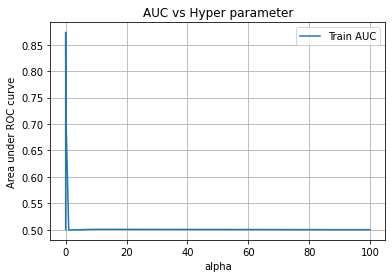

optimal alpha is 0.001 with best roc score 0.5


0.001

In [ ]:
sgd_classifierl1(bow_train,y_train,bow_test,y_test)

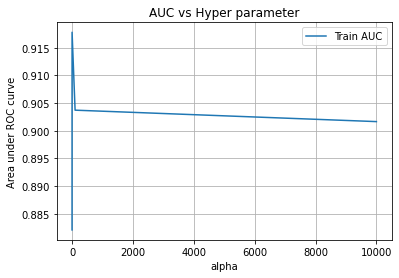

optimal alpha is 1 with best roc score 0.9040404444444445


1

In [ ]:
sgd_classifierl2(bow_train,y_train,bow_test,y_test)

Test data report
Best alpha 1


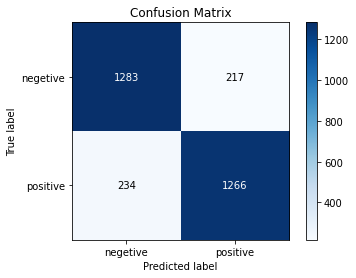

macro f1 score for data : 0.8496618391412791
micro f1 scoore for data: 0.8496666666666668
hamming loss for data: 0.15033333333333335
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.85      0.86      0.85      1500
    positive       0.85      0.84      0.85      1500

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000

test AUC 0.9194440000000002


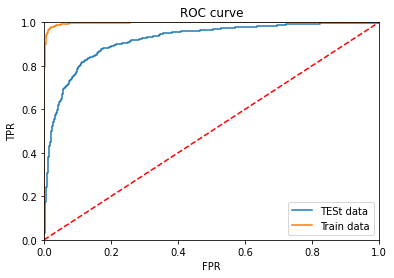

In [ ]:
testingmodel_l2(bow_train,bow_test,y_train,y_test,optimal_alpha=1)

Test data report
Best alpha 0.001


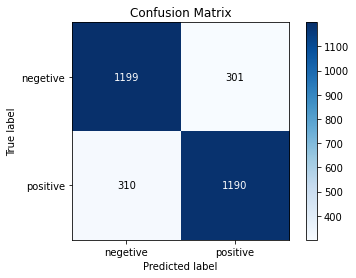

macro f1 score for data : 0.7963315003168361
micro f1 scoore for data: 0.7963333333333334
hamming loss for data: 0.20366666666666666
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.79      0.80      0.80      1500
    positive       0.80      0.79      0.80      1500

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000

test AUC 0.8591764444444444


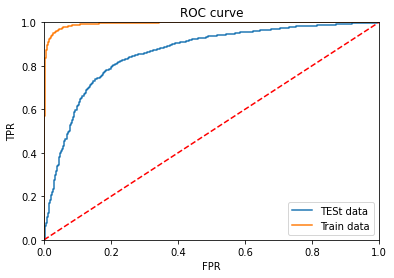

In [ ]:
testingmodel_l1(bow_train,bow_test,y_train,y_test,optimal_alpha=0.001)

In [ ]:
#Top 10 important features of L1 regularization
clf=SGDClassifier(alpha=0.001,loss='hinge', penalty='l1')
clf.fit(bow_train,y_train)
show_most_informative_features(count_vect,clf)

	-418.8832	snappl         		437.2725	panko          
	-399.9204	discontinuedrecal		437.2725	glutenwheat    
	-399.9204	ownermanufactur		437.2725	breadcrumb     
	-370.0416	contentcal     		427.8854	consol         
	-370.0416	despis         		427.8854	armor          
	-370.0416	ieinstead      		408.1370	wayi           
	-370.0416	pessimist      		408.1370	kickth         
	-370.0416	therenoth      		373.5362	rinc           
	-299.5109	ovaeasi        		361.5766	tasier         
	-298.3662	flipper        		361.5766	morningstar    


In [ ]:
clf1=SGDClassifier(alpha=1,loss='hinge', penalty='l2')
clf1.fit(bow_train,y_train)
show_most_informative_features(count_vect,clf1)

	-0.0690	not            		0.0879	great          
	-0.0684	disappoint     		0.0799	love           
	-0.0408	was            		0.0558	best           
	-0.0390	money          		0.0499	favorit        
	-0.0380	stale          		0.0489	delici         
	-0.0373	bad            		0.0460	excel          
	-0.0366	aw             		0.0406	good           
	-0.0362	terribl        		0.0398	perfect        
	-0.0362	worst          		0.0346	easi           
	-0.0343	tast           		0.0339	nice           


# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec=TfidfVectorizer(ngram_range=(1,2))
tf_train=tfidf_vec.fit_transform(X_train)
tf_test=tfidf_vec.transform(X_test)

In [ ]:
#normalize data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
tf_train=sc.fit_transform(tf_train)
tf_test=sc.transform(tf_test)


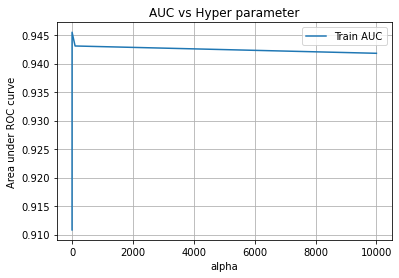

optimal alpha is 1 with best roc score 0.9203702222222222


1

In [ ]:
sgd_classifierl2(tf_train,y_train,tf_test,y_test)

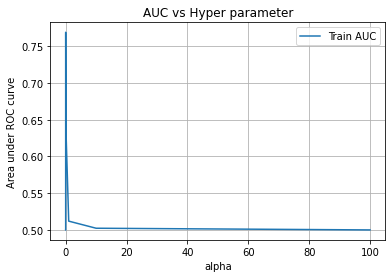

optimal alpha is 0.01 with best roc score 0.5


0.01

In [ ]:
sgd_classifierl1(tf_train,y_train,tf_test,y_test)

Test data report
Best alpha 0.01


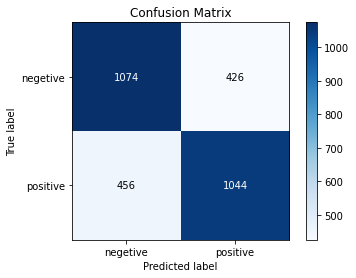

macro f1 score for data : 0.7059705970597059
micro f1 scoore for data: 0.706
hamming loss for data: 0.294
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.70      0.72      0.71      1500
    positive       0.71      0.70      0.70      1500

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000

test AUC 0.7235391111111111


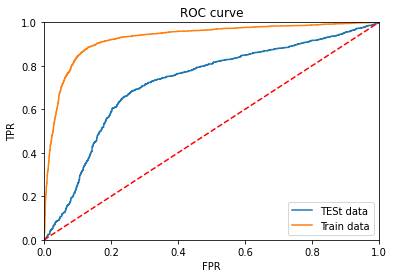

In [ ]:
testingmodel_l1(tf_train,tf_test,y_train,y_test,optimal_alpha=0.01)

Test data report
Best alpha 1


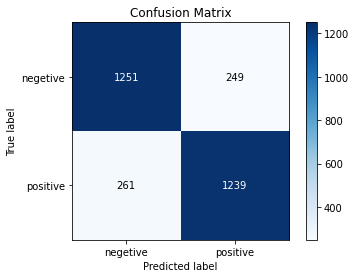

macro f1 score for data : 0.8299972799564793
micro f1 scoore for data: 0.83
hamming loss for data: 0.17
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.83      0.83      0.83      1500
    positive       0.83      0.83      0.83      1500

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

test AUC 0.9179484444444445


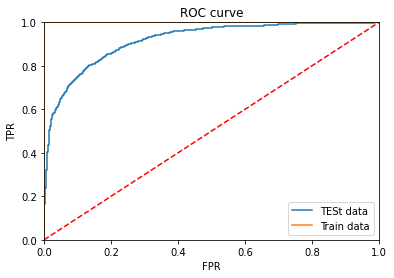

In [ ]:
testingmodel_l2(tf_train,tf_test,y_train,y_test,optimal_alpha=1)

In [ ]:
#Top 10 important features of L1 regularization
clf=SGDClassifier(alpha=0.01,loss='hinge', penalty='l1')
clf.fit(tf_train,y_train)
show_most_informative_features(tfidf_vec,clf)

	-222.5607	easi mac       		252.2714	will readi     
	-222.5607	kraft easi     		252.2714	week veri      
	-222.5607	alfredo pleas  		252.2714	websitei have  
	-222.5607	amazon consum  		252.2714	websitei       
	-222.5607	and alfredo    		252.2714	tire buy       
	-222.5607	ani occas      		252.2714	time hoursbut  
	-222.5607	anyon grossli  		252.2714	their websitei 
	-222.5607	are portabl    		252.2714	that room      
	-222.5607	are turn       		252.2714	room brighten  
	-222.5607	avail sever    		252.2714	own herb       


In [ ]:
clf11=SGDClassifier(alpha=1,loss='hinge', penalty='l2')
clf.fit(tf_train,y_train)
show_most_informative_features(tfidf_vec,clf1)

	-0.0690	and lather     		0.0879	also incorpor  
	-0.0684	ago while      		0.0799	and bold       
	-0.0408	artifici want  		0.0558	act act        
	-0.0390	and flat       		0.0499	all wonder     
	-0.0380	appx ounc      		0.0489	againi         
	-0.0373	acclim         		0.0460	all own        
	-0.0366	accept now     		0.0406	also cheaper   
	-0.0362	are overlook   		0.0398	and see        
	-0.0362	asthma         		0.0346	alik           
	-0.0343	are larger     		0.0339	and into       


# **WORD2VEC**

In [ ]:
list_of_sent_train=[]
for sent in X_train:
  list_of_sent_train.append(sent.split())

list_of_sent_test=[]
for sent in X_test:
  list_of_sent_test.append(sent.split())

print(len(list_of_sent_train))
print(len(list_of_sent_test))

7000
3000


In [ ]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_words=list(w2v_model.wv.vocab)

In [ ]:
def avgw2v(list_of_sent):
  sent_vectors=[] #the avg-w2v each sentance /review is stored in list
  for sent in list_of_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
      if word in w2v_words:
        vec=w2v_model.wv[word]
        sent_vec+=vec
        cnt_words +=1
    if cnt_words!=0:
      sent_vec /=cnt_words
    sent_vectors.append(sent_vec)
  print(len(sent_vectors[0]))
  print(len(sent_vectors))
  return np.array(sent_vectors)

In [ ]:
train_avgw2v=avgw2v(list_of_sent_train)

50
7000


In [ ]:
test_avgw2v=avgw2v(list_of_sent_test)

50
3000


In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_avgw2v=sc.fit_transform(train_avgw2v)
test_avgw2v=sc.transform(test_avgw2v)

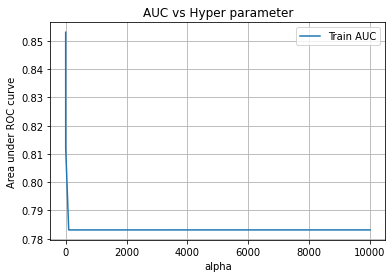

optimal alpha is 0.0001 with best roc score 0.7924786666666667


0.0001

In [ ]:
sgd_classifierl2(train_avgw2v,y_train,test_avgw2v,y_test)

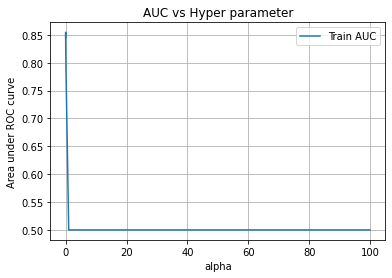

optimal alpha is 0.0001 with best roc score 0.5


0.0001

In [ ]:
sgd_classifierl1(train_avgw2v,y_train,test_avgw2v,y_test)

Test data report
Best alpha 0.0001


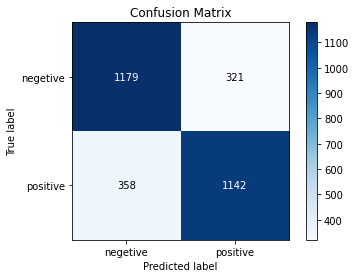

macro f1 score for data : 0.773632233614202
micro f1 scoore for data: 0.7736666666666666
hamming loss for data: 0.22633333333333333
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.77      0.79      0.78      1500
    positive       0.78      0.76      0.77      1500

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000

test AUC 0.8596742222222222


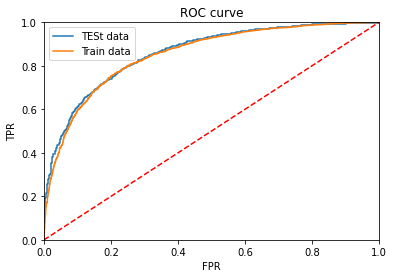

In [ ]:
testingmodel_l2(train_avgw2v,test_avgw2v,y_train,y_test,optimal_alpha=0.0001)

Test data report
Best alpha 0.001


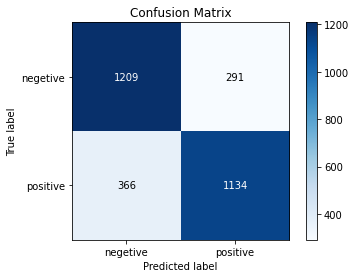

macro f1 score for data : 0.7808630393996248
micro f1 scoore for data: 0.7810000000000001
hamming loss for data: 0.219
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.77      0.81      0.79      1500
    positive       0.80      0.76      0.78      1500

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000

test AUC 0.8639862222222221


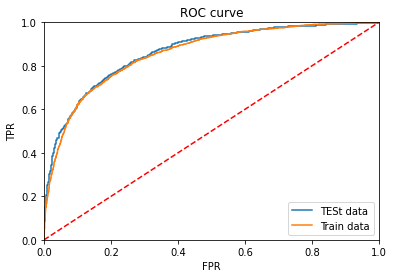

In [ ]:
testingmodel_l1(train_avgw2v,test_avgw2v,y_train,y_test,optimal_alpha=0.001)

## **TF-IDF W2V**

In [ ]:
#converting  a dictionary word as key and idf as value
dictionary=dict(zip(tfidf_vec.get_feature_names(),list(tfidf_vec.idf_)))

In [ ]:
def tfidfw2v(list_of_sent):
  tfidf_feat=tfidf_vec.get_feature_names()
  tfidf_sent_vectors=[]
  row=0
  for sent in list_of_sent:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
      if word in w2v_words and word in tfidf_feat:
        vec=w2v_model.wv[word]
        #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
        # to reduce the computation we are 
        #dictionary[word] = idf value of word in whole courpus
         #sent.count(word) = tf valeus of word in this review
        tf_idf=dictionary[word]*(sent.count(word)/len(sent))
        sent_vec+=tf_idf
        weight_sum+=tf_idf
    
    if weight_sum!=0:
      sent_vec /=weight_sum
    tfidf_sent_vectors.append(sent_vec)
  
  row+=1
  print(len(tfidf_sent_vectors))
  print(len(tfidf_sent_vectors[0]))
  return np.array(tfidf_sent_vectors)

In [ ]:
train_tfidf=tfidfw2v(list_of_sent_train)

7000
50


In [ ]:
test_tfidf=tfidfw2v(list_of_sent_test)

3000
50


In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_tfidf=sc.fit_transform(train_tfidf)
test_tfidf=sc.transform(test_tfidf)

In [ ]:
sgd_classifierl2(train_tfidf,y_train,test_tfidf,y_test)

In [ ]:
sgd_classifierl1(train_tfidf,y_train,test_tfidf,y_test)

In [ ]:
testingmodel_l1(train_tfidf,test_tfidf,y_train,y_test,optimal_alpha=1e-05)

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
test_scores = []
train_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(bow_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_test), y_score=clf.predict_proba(bow_test)[:,1])
        test_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(bow_train)[:,1])
        train_scores.append(scores)
        print("test ROC_AUC Score : ", test_scores[i], " Train ROC_AUC Score : ", train_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  degree :  4
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  degree :  4
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  degree :  4
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.001  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.001  degree :  4
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.01  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.01  degree :  4
[LibSVM]test ROC_AUC Score :  0.6078211111111111  Train ROC_AUC Score :  0.6263291428571428 C :  0.1  degree :  3
[LibSVM]test ROC_AUC Score

In [ ]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
test_scores = []
train_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(tf_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_test), y_score=clf.predict_proba(tf_test)[:,1])
        test_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(tf_train)[:,1])
        train_scores.append(scores)
        print('Test ROC_AUC Score : ', test_scores[i], " Train ROC_AUC Score : ", train_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  degree :  3
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  degree :  4
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  degree :  3
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  degree :  4
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  degree :  3
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  degree :  4
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.001  degree :  3
[LibSVM]Test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.001  degree :  4
[LibSVM]Test ROC_AUC Score :  0.49865933333333334  Train ROC_AUC Score :  0.49069999999999997 C :  0.01  degree :  3
[LibSVM]Test ROC_AUC Score :  0.48752177777777783  Train ROC_AUC Score :  0.44576538775510205 C :  0.01  degree :  4
[LibSVM]Test ROC_AUC Score :  0.5240262222222223  Train ROC_AUC Score :  0.6

In [ ]:
# Hyperparameter tuning :
degree = [3, 4]
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
test_scores = []
train_scores = []
i = 0
for alpha in C:
    for p in degree:
        clf = SVC(C=alpha, kernel='rbf',  degree=p, probability=True, verbose=10)
        clf.fit(train_avgw2v, y_train)
        scores = roc_auc_score(y_true=np.array(y_test), y_score=clf.predict_proba(test_avgw2v)[:,1])
        test_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_avgw2v)[:,1])
        train_scores.append(scores)
        print("test ROC_AUC Score : ", test_scores[i], " Train ROC_AUC Score : ", train_scores[i], "C : ", alpha, " degree : ", p)
        i += 1

[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  degree :  4
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  degree :  4
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  degree :  3
[LibSVM]test ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  degree :  4
[LibSVM]test ROC_AUC Score :  0.5365764444444444  Train ROC_AUC Score :  0.5374595918367346 C :  0.001  degree :  3
[LibSVM]test ROC_AUC Score :  0.5883482222222223  Train ROC_AUC Score :  0.5879320408163264 C :  0.001  degree :  4
[LibSVM]test ROC_AUC Score :  0.8134222222222223  Train ROC_AUC Score :  0.8060725714285715 C :  0.01  degree :  3
[LibSVM]test ROC_AUC Score :  0.8134071111111111  Train ROC_AUC Score :  0.8060894693877552 C :  0.01  degree :  4
[LibSVM]test ROC_AUC

In [ ]:
model=SVC(C=1,degree=4,kernel='rbf',probability=True)
model.fit(bow_train,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

**# Test Metrics**

In [ ]:
ypred=model.predict_proba(bow_test)[:,1]
pred=model.predict(bow_test)
roc_auc_score(y_test,ypred)

0.91377

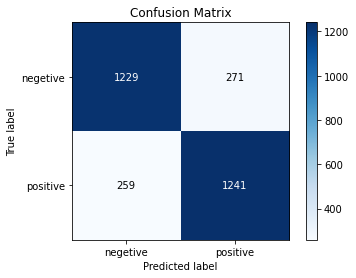

In [ ]:
#confusion  matrix

skplt.metrics.plot_confusion_matrix(y_test,pred)

In [ ]:
#TF idf
model1=SVC(C=10,degree=4,kernel='rbf',probability=True)
model1.fit(tf_train,y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [97]:
ypred= model1.predict_proba(tf_test)[:,1]
pred=model1.predict(tf_test)
roc_auc_score(y_test,ypred)

0.9284053333333334

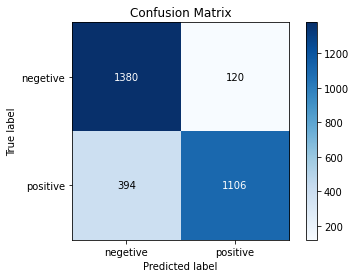

In [98]:
#confusion matrix
skplt.metrics.plot_confusion_matrix(y_test,pred)

In [99]:
model2=SVC(C=1,degree=3,kernel='rbf',probability=True)
model2.fit(train_avgw2v,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [102]:
ypred= model2.predict_proba(test_avgw2v)[:,1]
pred=model2.predict(test_avgw2v)
roc_auc_score(y_test,ypred)

0.8674208888888888

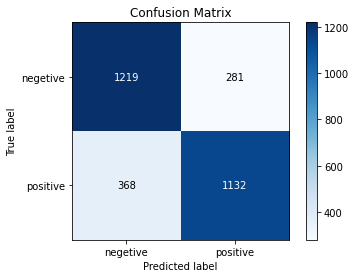

In [103]:
skplt.metrics.plot_confusion_matrix(y_test,pred)

In [106]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names=['Featurization','Hyperparameter(alpha)','Train AUC',' Test AUC','Penalty']
x.add_row(['BOW Lineal svm',1,89.42,91.94,'L2'])
x.add_row(['BOW Lineal svm',0.001,84.96,90.40,'L1'])
x.add_row(['TFIDF Lineal svm',1,86.48,91.79,'L2'])
x.add_row(['TFIDF Lineal svm',0.01,70.48,42.35,'L1'])
x.add_row(['avgw2v Lineal svm',0.0001,79.42,85.49,'L2'])
x.add_row(['avgw2v Lineal svm',0.001,78.10,86.32,'L1'])
print(x)

+-------------------+-----------------------+-----------+-----------+---------+
|   Featurization   | Hyperparameter(alpha) | Train AUC |  Test AUC | Penalty |
+-------------------+-----------------------+-----------+-----------+---------+
|   BOW Lineal svm  |           1           |   89.42   |   91.94   |    L2   |
|   BOW Lineal svm  |         0.001         |   84.96   |    90.4   |    L1   |
|  TFIDF Lineal svm |           1           |   86.48   |   91.79   |    L2   |
|  TFIDF Lineal svm |          0.01         |   70.48   |   42.35   |    L1   |
| avgw2v Lineal svm |         0.0001        |   79.42   |   85.49   |    L2   |
| avgw2v Lineal svm |         0.001         |    78.1   |   86.32   |    L1   |
+-------------------+-----------------------+-----------+-----------+---------+


# **Results**

In [108]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names=['Featurization','Hyperparameter(alpha)','Train AUC',' Test AUC','Penalty','degree']
x.add_row(['BOW Kernal svm',1,89.42,91.37,'L2',4])

x.add_row(['TFIDF kernel svm',10,89.52,92.81,'L2',4])

x.add_row(['avgw2v kernal svm',1,81.24,856.79,'L2',3])

print(x)

+-------------------+-----------------------+-----------+-----------+---------+--------+
|   Featurization   | Hyperparameter(alpha) | Train AUC |  Test AUC | Penalty | degree |
+-------------------+-----------------------+-----------+-----------+---------+--------+
|   BOW Kernal svm  |           1           |   89.42   |   91.37   |    L2   |   4    |
|  TFIDF kernel svm |           10          |   89.52   |   92.81   |    L2   |   4    |
| avgw2v kernal svm |           1           |   81.24   |   856.79  |    L2   |   3    |
+-------------------+-----------------------+-----------+-----------+---------+--------+
